## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import json

## Open folders

In [2]:
print(os.listdir("../input"))
print(os.listdir("../input/imaterialist-fashion-2019-FGVC6"))

['imaterialist-fashion-2019-FGVC6']
['test', 'sample_submission.csv', 'label_descriptions.json', 'train.csv', 'train']


## Open and load label_descriptions file

In [3]:
json_data=open("../input/imaterialist-fashion-2019-FGVC6/label_descriptions.json").read()
label_descriptions = json.loads(json_data)

# dataset info
label_descriptions['info']

{'year': 2019,
 'version': '1.0',
 'description': 'The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.',
 'contributor': 'iMaterialist Fashion Competition group',
 'url': 'https://github.com/visipedia/imat_comp',
 'date_created': '2019-04-19 12:38:27.493919'}

## First look at the categories

In [4]:
categories_label_df = pd.DataFrame(label_descriptions['categories'])

# Count categories
print("The number of categories : ",len(categories_label_df))
print("The number of subcategories : ",len(categories_label_df['supercategory'].unique()))

# Print first 5 rows
categories_label_df.head()

The number of categories :  46
The number of subcategories :  12


,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2


### Count: Group by subcategory:

In [5]:
categories_label_df.groupby('supercategory')['name'].count()

supercategory
arms and hands     2
closures           2
decorations       10
garment parts      7
head               3
legs and feet      4
lowerbody          3
neck               1
others             3
upperbody          6
waist              1
wholebody          4
Name: name, dtype: int64

### Count attributes

In [6]:
attributes_label_df = pd.DataFrame(label_descriptions['attributes'])
print("The number of attributes : ",len(attributes_label_df))

# Print first 5 rows
display(attributes_label_df.head())

The number of attributes :  92


,id,name,supercategory,level
0,0,above-the-hip (length),length,1
1,1,hip (length),length,1
2,2,micro (length),length,1
3,3,mini (length),length,1
4,4,above-the-knee (length),length,1


## Train data info: unique images, dataframe shape

In [7]:
train_df = pd.read_csv("../input/imaterialist-fashion-2019-FGVC6/train.csv")
print("dataframe shape:", train_df.shape)
print("number of unique images :",len(set(train_df['ImageId'])))

# Print first 5 rows
train_df.head(5)

dataframe shape: (331213, 5)
number of unique images : 45195


,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


## Identify Attributes: split ClassID column into Category and Attributes

In [8]:
train_df['Category'] = train_df['ClassId'].apply(lambda x: int(x.split("_")[0]))
train_df['Attributes'] = train_df['ClassId'].apply(lambda x: "_".join(x.split("_")[1:]))
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,Category,Attributes
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6,
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0,
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28,
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31,
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32,


## Count percentage:

In [9]:
# objects with attributes
print(f'Class objects with attributes: {train_df[train_df["Attributes"]!=""].shape[0]/train_df.shape[0]*100:.2f}%')

Class objects with attributes: 3.47%


In [10]:
# images with attributes
print(f'Images with attributes: {len(set(train_df[train_df["Attributes"]!=""]["ImageId"]))/len(set(train_df["ImageId"]))*100:.2f}%')

Images with attributes: 14.76%


## Simple statistics: histogram (number of images by category)

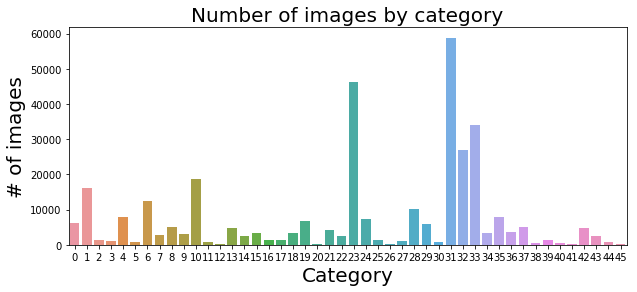

In [11]:
groupby_category = train_df.groupby('Category')['ImageId'].count()
groupby_category.index = map(int, groupby_category.index)
groupby_category = groupby_category.sort_index()
groupby_category[:5]

fig = plt.figure(figsize=(10, 4))
x = groupby_category.index
y = groupby_category.values

sns.barplot(x,y)
plt.title("Number of images by category", fontsize=20)
plt.xlabel("Category", fontsize=20)
plt.ylabel("# of images", fontsize=20)
plt.show()

### Count images by Category

In [12]:
# The Number of images with Attributes by Category
groupby_category_Having_attributes = train_df[['ImageId','Category']].groupby('Category').count()
groupby_category_Having_attributes.columns = ['# of imgs']

# Print first 5 rows
groupby_category_Having_attributes.head()

,# of imgs
Category,
0,6134
1,16230
2,1483
3,1105
4,7808


## Function: Show image

In [13]:
def show_img(IMG_FILE):
    I = cv2.imread("../input/imaterialist-fashion-2019-FGVC6/train/" + IMG_FILE, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    plt.imshow(I) 
    plt.tight_layout()
    plt.show()

## Open data: Image elements

In [14]:
train_df[train_df['ImageId']=='000aac3870ea7c59ca0333ffa5327323.jpg'].sort_values('Category')

,ImageId,EncodedPixels,Height,Width,ClassId,Category,Attributes
44,000aac3870ea7c59ca0333ffa5327323.jpg,8621972 2 8625970 5 8629968 9 8633966 13 86379...,4000,6000,3_1_10_20_41_60_61_91,3,1_10_20_41_60_61_91
42,000aac3870ea7c59ca0333ffa5327323.jpg,8971124 17 8975101 49 8979077 82 8983053 116 8...,4000,6000,10_3_20_34_56_69_91,10,3_20_34_56_69_91
45,000aac3870ea7c59ca0333ffa5327323.jpg,8621972 2 8625970 5 8629968 9 8633966 13 86379...,4000,6000,31,31,
46,000aac3870ea7c59ca0333ffa5327323.jpg,12985563 5 12989560 13 12993557 22 12997554 30...,4000,6000,31,31,
43,000aac3870ea7c59ca0333ffa5327323.jpg,10565221 1 10569218 5 10573216 8 10577213 11 1...,4000,6000,33,33,
47,000aac3870ea7c59ca0333ffa5327323.jpg,10357237 9 10361232 27 10365227 44 10369222 62...,4000,6000,33,33,


### Image example:

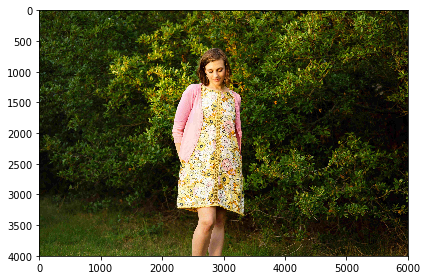

In [15]:
show_img('000aac3870ea7c59ca0333ffa5327323.jpg')

## Function: Create mask, which defines items on the image

In [16]:
def make_mask(IMG_FILE):
    df = train_df[train_df.ImageId == IMG_FILE].reset_index(drop = True)
    H = df.iloc[0,2]
    W = df.iloc[0,3]
    
    print("Correct Category :", sorted(set((list(df.Category)))))
    # 1d mask 
    mask = np.full(H*W,dtype='int',fill_value = -1)
    
    for line in df[['EncodedPixels','Category']].iterrows():
        EncodedPixels = line[1][0]
        Category = line[1][1]
        
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = Category
    
    print("Output :",sorted(set(list(mask))))
    #rle
    mask = mask.reshape(W,H).T
    
    return mask

### Example:

Correct Category : [3, 10, 31, 33]
Output : [-1, 3, 10, 31, 33]


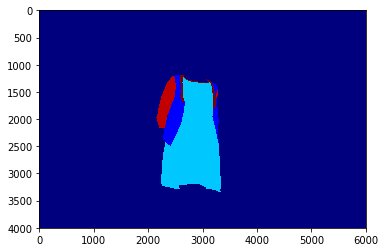

In [17]:
mask = make_mask('000aac3870ea7c59ca0333ffa5327323.jpg')
plt.imshow(mask,cmap='jet')

## Function: open image and mask, combine them

In [18]:
def Masking_Image(IMG_FILE):
        
    I = cv2.imread("../input/imaterialist-fashion-2019-FGVC6/train/" + IMG_FILE, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    mask = make_mask(IMG_FILE)

    fig, ax = plt.subplots(nrows = 1, ncols = 3,figsize = (18,6))
    
    ax[0].imshow(I)
    ax[1].imshow(mask, cmap = 'jet')
    ax[2].imshow(I,interpolation = 'none')
    ax[2].imshow(mask,cmap = 'jet', interpolation = 'none', alpha = 0.6)

### Example:

Correct Category : [3, 10, 31, 33]
Output : [-1, 3, 10, 31, 33]


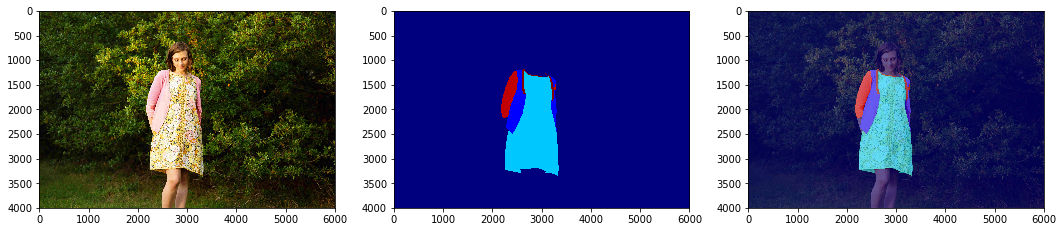

In [19]:
Masking_Image('000aac3870ea7c59ca0333ffa5327323.jpg')